### ESBM for recommender systems

LAST FULL FUN 23/04 9:20

In [6]:
#!uv pip install -q --system numba-cuda==0.4.0

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import Counter
from collections import OrderedDict
from scipy.special import gamma
import scipy.special as sc
import numba as nb
from scipy.special import gammaln
import time
import seaborn as sns
from math import lgamma
from numba import cuda
from scipy.stats import mode
from functs2 import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix

In [8]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows")

In [9]:
# from numba import config
# config.CUDA_ENABLE_PYNVJITLINK = 1

In [10]:
# implement cov processing
n_users = 100
n_items = 100
n_cl_u = 5
n_cl_i = 8

np.random.seed(1)
user_clustering = list(np.random.choice([0,1,2,3], p=[0.6, 0.2, 0.15, 0.05],size=n_users))
t = np.array([1 if user_clustering[i]%2==0 else 0 for i in range(n_users)])
t[np.random.randint(0, len(t), size=25)] = 0
cov_users = [('gender_cat', t.copy())]

item_clustering = list(np.random.choice([0,1,2,3], p=[0.5, 0.25, 0.2, 0.05],size=n_items))
t3 = np.array([1 if item_clustering[i]%2==0 else 0 for i in range(n_items)])
t3[np.random.randint(0, len(t3), size=25)] = 0
cov_items = [('genre_cat', t3.copy()) for _ in range(1)]

theta = np.array([
    [0.1, 1.5, 0.1, 1.5],
    [1.5, 0.1, 1.5, 0.1],
    [0.1, 1.5, 0.1, 1.5],
    [1.5, 0.1, 1.5, 0.1],
    ])

params = {
    'num_users':n_users,
    'num_items': n_items,
    'user_clustering':user_clustering,
    'item_clustering':item_clustering,
    #'theta':theta,
    'prior_a':1,
    'prior_b':1,
    'seed':1,
    'scheme_type':'DM',
    'scheme_param':1,
    #'scheme_param_items':1, 
    'bar_h_users':4,
    'bar_h_items':4,
    'sigma':-0.9,
    'epsilon':1e-30,
    'gamma':0.9,
    'cov_users':cov_users,
    'cov_items':cov_items,
    'alpha_c':[1.5, 1.5, 1.5,1.5, 1.5],
}


model = dcesbm(degree_param_users=10, degree_param_items=10, **params)

compute_log_likelihood(nh = model.frequencies_users, nk = model.frequencies_items, a = model.prior_a, 
                             b = model.prior_b, eps = model.epsilon, mhk=model.compute_mhk(), 
                             user_clustering=model.user_clustering, 
                             item_clustering=model.item_clustering,
                             degree_param_users=1,
                             degree_param_items=1,
                             dg_u=np.zeros(model.num_users), 
                             dg_i=np.zeros(model.num_items), 
                             dg_cl_i=np.zeros(model.n_clusters_items), 
                             dg_cl_u=np.zeros(model.n_clusters_users),
                             degree_corrected=False)

randomly initialising data


-6853.067167787129

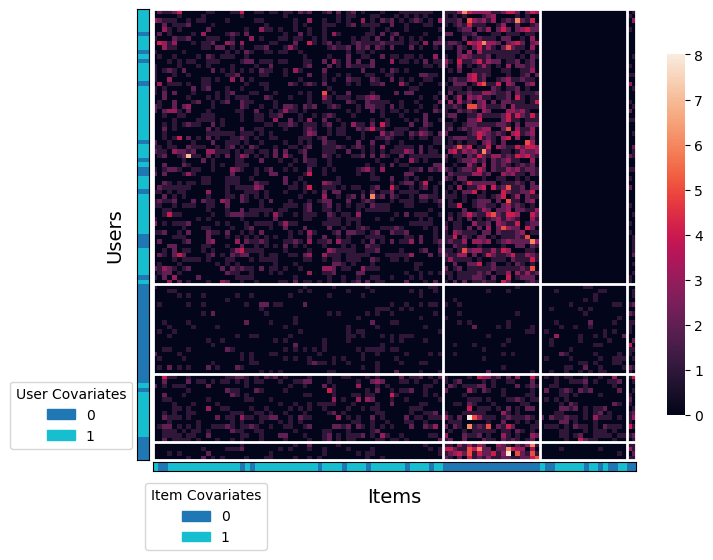

In [11]:
plot_heatmap(model, size=(8,6), user_covariates = model.cov_values_users[0], item_covariates=model.cov_values_items[0], add_labels=False)

### Generate validation set

In [12]:
def generate_val_set(y, size=0.1, seed=42, only_observed=True):
    np.random.seed(seed)
    n_users, n_items = y.shape
    n_val = int(size*n_users*n_items)
    y_val = []
    for _ in range(n_val):
        u = np.random.randint(n_users)
        i = np.random.randint(n_items)
        if only_observed:
            while y[u,i] == 0:
                u = np.random.randint(n_users)
                i = np.random.randint(n_items)
        y_val.append((u,i, int(y[u,i])))
    
    y_train = y.copy()
    for u,i, _ in y_val:
        y_train[u,i] = 0
    
    return y_train, y_val

In [13]:
Y_train, Y_val = generate_val_set(model.Y, size=0.1, seed=42, only_observed=False)

In [14]:
# np.save('train_dt.npy', Y_train)
# np.save('val_dt.npy', Y_val)
# np.save('full_dt.npy', model.Y)

In [15]:
# np.save('cov_users.npy', model.cov_values_users[0])
# np.save('cov_items.npy', model.cov_values_items[0])

In [16]:
Y_train.shape

(100, 100)

In [17]:
def validate_models(Y_train, Y_val, model_list, param_list, n_iters=500, burn_in=None, verbose=0,
                    thinning=3, model_names=None, true_users=None, true_items=None, k=None,
                    print_intermid=False):
    if burn_in is None:
        burn_in = n_iters//2
    
    Y_val_pairs = [(u,i) for u,i,_ in Y_val]
    Y_val_users = [u for u,_,_ in Y_val]
    Y_val_items = [i for _,i,_ in Y_val]
    Y_val_ratings = [r for _,_,r in Y_val]
    
    
    val_users_relevant = {}

    for j in range(len(Y_val_pairs)):
        u = Y_val_users[j]
        i = Y_val_items[j]
        r = Y_val_ratings[j]
        if u not in val_users_relevant:
            val_users_relevant[u] = [] 
        if r > 1:
            val_users_relevant[u].append(i)
    
    val_users_unique = list(val_users_relevant.keys())
    
    model_list_out = []
    
    for i in range(len(model_list)):
        if model_names is not None:
            name = model_names[i]
        else:
            name = i
            
        print('\nModel name:', name)
            
        model_type = model_list[i]
        params = param_list[i]
        model = model_type(Y=Y_train, num_users=Y_train.shape[0], num_items=Y_train.shape[1], **params)
        print('Starting training for model', name)
        llk_model, user_cl_model, item_cl_model = model.gibbs_train(n_iters, verbose=verbose)
        model_est_users, model_est_items, model_vi_users, model_vi_items = model.estimate_cluster_assignment_vi(burn_in=burn_in, thinning=thinning)
        
        waic_model = None
        
        
        print('Starting waic computation', name)        
        llk_edges = []
        # for iter in range(burn_in, model.n_iters, thinning):
        #     llk_edges.append(model.compute_llk(iter))
        # waic_model = waic_calculation(np.array(llk_edges))
        
        print('Starting prediction for model', name)
        model_ratings = model.point_predict(Y_val_pairs, seed=42)
        mae_model = mean_absolute_error(Y_val_ratings, model_ratings)
        mse_model = mean_squared_error(Y_val_ratings, model_ratings)    
        
        print('Starting ranking for model', name)
        if k is None:
            ranks_model = model.predict_with_ranking(val_users_unique)
        else:
            ranks_model = model.predict_k(val_users_unique, k=k)
            
        precision_list_model = []   
        recall_list_model = []
        for j in range(len(val_users_unique)):
            if len(val_users_relevant[val_users_unique[j]]) == 0:
                continue
            precision_list_model.append(compute_precision(val_users_relevant[val_users_unique[j]], ranks_model[j]))
            recall_list_model.append(compute_recall(val_users_relevant[val_users_unique[j]], ranks_model[j]))
        precision_model = sum(precision_list_model)/len(precision_list_model)
        recall_model = sum(recall_list_model)/len(recall_list_model)
        
        if true_users is not None:
            vi_users_model = VI(true_users, model.user_clustering)[0]
            model.vi_users = vi_users_model
        if true_items is not None:
            vi_items_model = VI(true_items, model.item_clustering)[0]
            model.vi_items = vi_items_model
        
        model.precision_ranks = precision_model
        model.recall_ranks = recall_model
        model.mae = mae_model
        model.mse = mse_model
        model.waic = waic_model
        model.llk_edges = llk_edges
        
        if print_intermid is True:
            print('MAE:', mae_model)
            print('MSE:', mse_model)
            print('Precision:', precision_model)
            print('Recall:', recall_model)
            if true_users is not None:
                print('VI users:', vi_users_model)
            if true_items is not None:
                print('VI items:', vi_items_model)
            if waic_model is not None:
                print('WAIC:', waic_model)
        
        model_list_out.append(model)
        
    return model_list_out

In [18]:
Y_val_pairs = [(x[0], x[1]) for x in Y_val]
Y_val_users = [x[0] for x in Y_val]
Y_val_items = [x[1] for x in Y_val]
Y_val_ratings = [x[2] for x in Y_val]

In [19]:
val_users_relevant = {}

for j in range(len(Y_val_pairs)):
    u = Y_val_users[j]
    i = Y_val_items[j]
    r = Y_val_ratings[j]
    if u not in val_users_relevant:
        val_users_relevant[u] = [] 
    if r > 1:
        val_users_relevant[u].append(i)

In [20]:
def multiple_runs(num_users, num_items, n_clu_u, n_cl_i, n_runs, 
                  n_iters, params_list, model_list, model_names,
                  cov_places_items=None, cov_places_users=None,
                  k = 10, print_intermid=True, verbose=1, 
                  burn_in=0, thinning=1, seed=0):
    params_init = {
        'num_users':num_users,
        'num_items': num_items,
        'user_clustering':'random',
        'item_clustering':'random',
        'degree_param_users':10,
        'degree_param_items':10,
        'prior_a':1,
        'prior_b':1,
        'seed':1,
        'scheme_type':'DM',
        'scheme_param':1,
        'bar_h_users':n_clu_u,
        'bar_h_items':n_cl_i,
        'sigma':-0.9,
        'epsilon':1e-30,
        'gamma':0.9,
        'alpha_c':[1.5, 1.5, 1.5,1.5, 1.5],
        'degree_param_users':10,
        'degree_param_items':10}
    
    names_list = []
    models_list_out = []
    mse_list = []
    mae_list = []
    precision_list = []
    recall_list = []
    vi_users_list = []
    vi_items_list = []
    
    for r in range(n_runs):
        try:
            np.random.seed(seed+r)
            user_clustering = list(np.random.choice([0,1,2,3], p=[0.6, 0.2, 0.15, 0.05],size=num_users))
            t = np.array([1 if user_clustering[i]%2==0 else 0 for i in range(num_users)])
            t[np.random.randint(0, len(t), size=25)] = 0
            cov_users = [('gender_cat', t.copy())]

            item_clustering = list(np.random.choice([0,1,2,3], p=[0.5, 0.25, 0.2, 0.05],size=num_items))
            t3 = np.array([1 if item_clustering[i]%2==0 else 0 for i in range(num_items)])
            t3[np.random.randint(0, len(t3), size=25)] = 0
            cov_items = [('genre_cat', t3.copy()) for _ in range(1)]
            
            params_init['user_clustering'] = user_clustering
            params_init['item_clustering'] = item_clustering
            params_init['cov_users'] = cov_users
            params_init['cov_items'] = cov_items        
            params_init['seed'] = seed+r
            true_model = dcesbm(**params_init)
            Y_train, Y_val = generate_val_set(true_model.Y, size=0.1, seed=42, only_observed=False)
            true_users = true_model.user_clustering.copy()
            true_items = true_model.item_clustering.copy()
            
            if cov_places_users is not None:
                for place in cov_places_users:
                    params_list[place]['cov_users'] = cov_users
            if cov_places_items is not None:
                for place in cov_places_items:
                    params_list[place]['cov_items'] = cov_items
            
            out = validate_models(Y_train, Y_val, model_list, params_list, n_iters=n_iters, burn_in=burn_in, k = k, 
                                verbose=verbose, thinning=thinning, model_names=model_names, true_users=true_users, 
                                true_items=true_items, print_intermid=print_intermid)
            
            for m in range(len(out)):
                names_list.append(model_names[m])
                mse_list.append(out[m].mse)
                mae_list.append(out[m].mae)
                precision_list.append(out[m].precision_ranks)
                recall_list.append(out[m].recall_ranks)
                vi_users_list.append(out[m].vi_users)
                vi_items_list.append(out[m].vi_items)
                models_list_out.append(out[m])
        except Exception as e:
            print('Error in run', r, 'with error:', e)
            continue
            
    
    return names_list, mse_list, mae_list, precision_list, recall_list, vi_users_list, vi_items_list, models_list_out

## Degree-corrected models

In [21]:
burn_in = 2000
thinning = 2
n_iters = 4000
k = 10

true_users = model.user_clustering.copy()
true_items = model.item_clustering.copy()

In [22]:
params_baseline = {'cov_users':None,'cov_items':None, 'prior_a':1, 'prior_b':1, 'seed':42, 'bar_h_users':2, 'bar_h_items':3,
           'scheme_param':1, 'gamma':0.1, 'epsilon':1e-30, 'sigma':0.7, 'alpha_c':[1.5, 1.5, 1.5, 1.5]}#, 'user_clustering':'random', 'item_clustering':'random'}

params_dp = params_baseline.copy()

params_dp['prior_a'] = 1
params_dp['prior_b'] = 1
params_dp['degree_param_users'] = 10
params_dp['degree_param_items'] = 10
params_dp['scheme_param'] = 2
params_dp['sigma'] = 0.329
params_dp['scheme_type'] = 'DP'

params_py = params_baseline.copy()
params_py['prior_a'] = 1
params_py['prior_b'] = 1
params_py['degree_param_users'] = 10
params_py['degree_param_items'] = 10
params_py['scheme_param'] = 1.3
params_py['sigma'] = 0.1
params_py['scheme_type'] = 'PY'

params_gn = params_baseline.copy()
params_gn['prior_a'] = 1
params_gn['prior_b'] = 1
params_gn['degree_param_users'] = 10
params_gn['degree_param_items'] = 10
params_gn['gamma'] = 0.55
params_gn['scheme_type'] = 'GN'

params_dp_cov = params_baseline.copy()
params_dp_cov['prior_a'] = 1
params_dp_cov['prior_b'] = 1
params_dp_cov['degree_param_users'] = 2
params_dp_cov['degree_param_items'] = 2
params_dp_cov['scheme_param'] = 2
params_dp_cov['cov_users'] = cov_users
params_dp_cov['cov_items'] = cov_items
params_dp_cov['scheme_type'] = 'DP'

params_py_cov = params_baseline.copy()
params_py_cov['prior_a'] = 1
params_py_cov['prior_b'] = 1
params_py_cov['degree_param_users'] = 2
params_py_cov['degree_param_items'] = 2
params_py_cov['scheme_param'] = 1.3
params_py_cov['sigma'] = 0.1
params_py_cov['cov_users'] = cov_users
params_py_cov['cov_items'] = cov_items
params_py_cov['scheme_type'] = 'PY'

params_gn_cov = params_baseline.copy()
params_gn_cov['prior_a'] = 1
params_gn_cov['prior_b'] = 1
params_gn_cov['degree_param_users'] = 2
params_gn_cov['degree_param_items'] = 2
params_gn_cov['gamma'] = 0.55
params_gn_cov['cov_users'] = cov_users
params_gn_cov['cov_items'] = cov_items
params_gn_cov['scheme_type'] = 'GN'

model_list = [dcesbm, dcesbm, dcesbm, dcesbm, dcesbm, dcesbm]
params_list = [params_dp, params_py, params_gn, params_dp_cov, params_py_cov, params_gn_cov]
model_names = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']

In [23]:
names_list, mse_list, mae_list, precision_list, recall_list, vi_users_list, vi_items_list, models_list_out = multiple_runs(
    num_users=100, num_items=100, n_clu_u=4, n_cl_i=4, n_runs=10, n_iters= 4000,
    params_list=params_list, model_list=model_list, model_names=model_names, cov_places_users=[3,4,5],
    cov_places_items=[3,4,5], k = 10, print_intermid=True, verbose=1, burn_in=1000, thinning=1, seed=1)

randomly initialising data

Model name: DP
Starting training for model DP
starting log likelihood -8806.023828870588
0 -6665.526050735657
time 1.6589419841766357
400 -6365.4897230914685
time 2.781403064727783
800 -6368.687295401001
time 2.91522216796875
1200 -6374.643600738734
time 2.7408640384674072
1600 -6365.656486714206
time 2.6653690338134766
2000 -6378.300185306123
time 2.753938913345337
2400 -6365.893399023521
time 2.7184460163116455


KeyboardInterrupt: 

In [ ]:
mean_dp_mse = np.mean(mse_list[0::6])
mean_py_mse = np.mean(mse_list[1::6])
mean_gn_mse = np.mean(mse_list[2::6])
mean_dp_cov_mse = np.mean(mse_list[3::6])
mean_py_cov_mse = np.mean(mse_list[4::6])
mean_gn_cov_mse = np.mean(mse_list[5::6])

mean_dp_mae = np.mean(mae_list[0::6])
mean_py_mae = np.mean(mae_list[1::6])
mean_gn_mae = np.mean(mae_list[2::6])
mean_dp_cov_mae = np.mean(mae_list[3::6])
mean_py_cov_mae = np.mean(mae_list[4::6])
mean_gn_cov_mae = np.mean(mae_list[5::6])

mean_dp_prec = np.mean(precision_list[0::6])
mean_py_prec = np.mean(precision_list[1::6])
mean_gn_prec = np.mean(precision_list[2::6])
mean_dp_cov_prec = np.mean(precision_list[3::6])
mean_py_cov_prec = np.mean(precision_list[4::6])
mean_gn_cov_prec = np.mean(precision_list[5::6])

mean_dp_rec = np.mean(recall_list[0::6])
mean_py_rec = np.mean(recall_list[1::6])
mean_gn_rec = np.mean(recall_list[2::6])
mean_dp_cov_rec = np.mean(recall_list[3::6])
mean_py_cov_rec = np.mean(recall_list[4::6])
mean_gn_cov_rec = np.mean(recall_list[5::6])

mean_dp_vi_users = np.mean(vi_users_list[0::6])
mean_py_vi_users = np.mean(vi_users_list[1::6])
mean_gn_vi_users = np.mean(vi_users_list[2::6])
mean_dp_cov_vi_users = np.mean(vi_users_list[3::6])
mean_py_cov_vi_users = np.mean(vi_users_list[4::6])
mean_gn_cov_vi_users = np.mean(vi_users_list[5::6])

mean_dp_vi_items = np.mean(vi_items_list[0::6])
mean_py_vi_items = np.mean(vi_items_list[1::6])
mean_gn_vi_items = np.mean(vi_items_list[2::6])
mean_dp_cov_vi_items = np.mean(vi_items_list[3::6])
mean_py_cov_vi_items = np.mean(vi_items_list[4::6])
mean_gn_cov_vi_items = np.mean(vi_items_list[5::6])

In [ ]:
output_table = pd.DataFrame()

output_table['Model'] = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']
output_table['MAE'] = [mean_dp_mae, mean_py_mae, mean_gn_mae, mean_dp_cov_mae, mean_py_cov_mae, mean_gn_cov_mae]
output_table['MSE'] = [mean_dp_mse, mean_py_mse, mean_gn_mse, mean_dp_cov_mse, mean_py_cov_mse, mean_gn_cov_mse]
output_table['Precision'] = [mean_dp_prec, mean_py_prec, mean_gn_prec, mean_dp_cov_prec, mean_py_cov_prec, mean_gn_cov_prec]
output_table['Recall'] = [mean_dp_rec, mean_py_rec, mean_gn_rec, mean_dp_cov_rec, mean_py_cov_rec, mean_gn_cov_rec]
output_table['VI_users'] = [mean_dp_vi_users, mean_py_vi_users, mean_gn_vi_users, mean_dp_cov_vi_users, mean_py_cov_vi_users, mean_gn_cov_vi_users]
output_table['VI_items'] = [mean_dp_vi_items, mean_py_vi_items, mean_gn_vi_items, mean_dp_cov_vi_items, mean_py_cov_vi_items, mean_gn_cov_vi_items]

output_table

,Model,MAE,MSE,Precision,Recall,VI_users,VI_items
0,DP,0.678940,1.178134,0.201179,0.660942,0.171815,0.216072
1,PY,0.676253,1.127313,0.201432,0.660319,0.182480,0.267068
2,GN,0.671920,1.101184,0.201757,0.659152,0.105671,0.262897
3,DP_cov,0.673467,1.122763,0.201662,0.665803,0.101258,0.251704
4,PY_cov,0.671781,1.119345,0.202183,0.665214,0.113818,0.212888
5,GN_cov,0.666940,1.079049,0.203039,0.665443,0.069704,0.195482


In [ ]:
model_dp_dc = models_list_out[-6]
model_py_dc = models_list_out[-5]
model_gn_dc = models_list_out[-4]
model_dp_cov_dc = models_list_out[-3]
model_py_cov_dc = models_list_out[-2]
model_gn_cov_dc = models_list_out[-1]

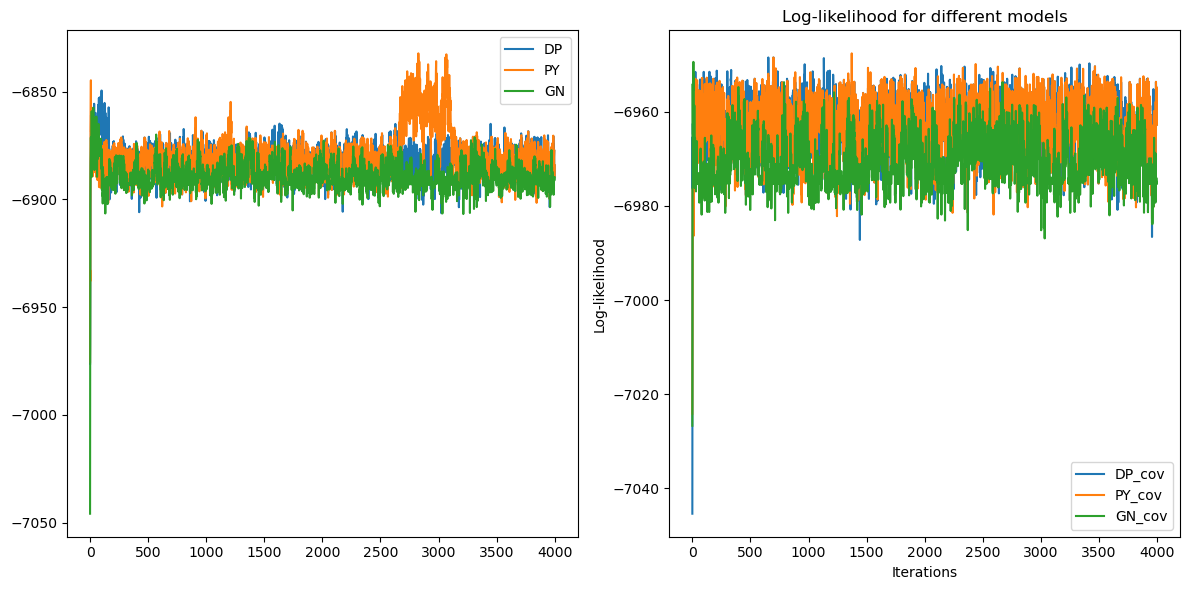

In [ ]:
llk_dp = model_dp_dc.train_llk
llk_py = model_py_dc.train_llk
llk_gn = model_gn_dc.train_llk

llk_dp_cov = model_dp_cov_dc.train_llk
llk_py_cov = model_py_cov_dc.train_llk
llk_gn_cov = model_gn_cov_dc.train_llk

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(llk_dp[2:], label='DP')
ax[0].plot(llk_py[2:], label='PY')
ax[0].plot(llk_gn[2:], label='GN')
ax[0].legend()

ax[1].plot(llk_dp_cov[2:], label='DP_cov')
ax[1].plot(llk_py_cov[2:], label='PY_cov')
ax[1].plot(llk_gn_cov[2:], label='GN_cov')
ax[1].legend()

plt.title('Log-likelihood for different models')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

plt.tight_layout()
plt.show()

## Non dc model

In [ ]:
params_baseline = {'cov_users':None,'cov_items':None, 'prior_a':1, 'prior_b':1, 'seed':42, 'scheme_param':1, 'bar_h_users':2, 'bar_h_items':3,
           'gamma':0.1, 'epsilon':1e-30, 'sigma':0.7, 'alpha_c':[1.5, 1.5, 1.5, 1.5]}

params_dp = params_baseline.copy()

params_dp['prior_a'] = 1
params_dp['prior_b'] = 1
params_dp['scheme_param'] = 2
params_dp['sigma'] = 0.329
params_dp['scheme_type'] = 'DP'

params_py = params_baseline.copy()
params_py['prior_a'] = 1
params_py['prior_b'] = 1
params_py['scheme_param'] = 1.3
params_py['sigma'] = 0.1
params_py['scheme_type'] = 'PY'

params_gn = params_baseline.copy()
params_gn['prior_a'] = 1
params_gn['prior_b'] = 1
params_gn['gamma'] = 0.55
params_gn['scheme_type'] = 'GN'

params_dp_cov = params_baseline.copy()
params_dp_cov['prior_a'] = 1
params_dp_cov['prior_b'] = 1
params_dp_cov['scheme_param'] = 2
params_dp_cov['cov_users'] = cov_users
params_dp_cov['cov_items'] = cov_items
params_dp_cov['scheme_type'] = 'DP'

params_py_cov = params_baseline.copy()
params_py_cov['prior_a'] = 1
params_py_cov['prior_b'] = 1
params_py_cov['scheme_param'] = 1.3
params_py_cov['sigma'] = 0.1
params_py_cov['cov_users'] = cov_users
params_py_cov['cov_items'] = cov_items
params_py_cov['scheme_type'] = 'PY'

params_gn_cov = params_baseline.copy()
params_gn_cov['prior_a'] = 1
params_gn_cov['prior_b'] = 1
params_gn_cov['gamma'] = 0.55
params_gn_cov['cov_users'] = cov_users
params_gn_cov['cov_items'] = cov_items
params_gn_cov['scheme_type'] = 'GN'

model_list_esbm = [esbm, esbm, esbm, esbm, esbm, esbm]
params_list_esbm = [params_dp, params_py, params_gn, params_dp_cov, params_py_cov, params_gn_cov]
model_names_esbm = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']

In [ ]:
out_esbm = multiple_runs(num_users=100, num_items=100, n_clu_u=4, n_cl_i=4, n_runs=10, n_iters= 4000,
                         params_list=params_list_esbm, model_list=model_list_esbm, model_names=model_names_esbm, 
                         cov_places_users=[3,4,5], cov_places_items=[3,4,5], k = 10, print_intermid=True, verbose=1, 
                         burn_in=1000, thinning=1, seed=1)

randomly initialising data

Model name: DP
Starting training for model DP
starting log likelihood -8806.023828870588
0 -6652.194285664274
400 -6319.077475734668
800 -6330.112640488088
1200 -6325.514353169619
1600 -6328.408391955791
2000 -6327.654791503562
2400 -6318.5664053549
2800 -6318.631097290082
3200 -6314.992982333021
3600 -6312.718103609428
end llk:  -6314.914357470397
Starting waic computation DP
Starting prediction for model DP
Starting ranking for model DP
MAE: 0.5010460446006814
MSE: 0.5470155971179372
Precision: 0.10200000000000001
Recall: 0.532
VI users: 0.876210588833178
VI items: 1.2118551712780241

Model name: PY
Starting training for model PY
starting log likelihood -8806.023828870588
0 -6624.544393021718
400 -6312.053359554041
800 -6315.250326727955
1200 -6300.315513925791
1600 -6331.077570135977
2000 -6318.318696372284
2400 -6328.716723494744
2800 -6317.3008741211825
3200 -6327.081210159118
3600 -6330.1827380260875
end llk:  -6341.081745317722
Starting waic computati

In [ ]:
names_list_esbm, mse_list_esbm, mae_list_esbm, precision_list_esbm, recall_list_esbm, vi_users_list_esbm, vi_items_list_esbm, models_list_out_esbm = out_esbm

In [ ]:
mean_dp_mse_esbm = np.mean(mse_list_esbm[0::6])
mean_py_mse_esbm = np.mean(mse_list_esbm[1::6])
mean_gn_mse_esbm = np.mean(mse_list_esbm[2::6])
mean_dp_cov_mse_esbm = np.mean(mse_list_esbm[3::6])
mean_py_cov_mse_esbm = np.mean(mse_list_esbm[4::6])
mean_gn_cov_mse_esbm = np.mean(mse_list_esbm[5::6])

mean_dp_mae_esbm = np.mean(mae_list_esbm[0::6])
mean_py_mae_esbm = np.mean(mae_list_esbm[1::6])
mean_gn_mae_esbm = np.mean(mae_list_esbm[2::6])
mean_dp_cov_mae_esbm = np.mean(mae_list_esbm[3::6])
mean_py_cov_mae_esbm = np.mean(mae_list_esbm[4::6])
mean_gn_cov_mae_esbm = np.mean(mae_list_esbm[5::6])

mean_dp_prec_esbm = np.mean(precision_list_esbm[0::6])
mean_py_prec_esbm = np.mean(precision_list_esbm[1::6])
mean_gn_prec_esbm = np.mean(precision_list_esbm[2::6])
mean_dp_cov_prec_esbm = np.mean(precision_list_esbm[3::6])
mean_py_cov_prec_esbm = np.mean(precision_list_esbm[4::6])
mean_gn_cov_prec_esbm = np.mean(precision_list_esbm[5::6])

mean_dp_rec_esbm = np.mean(recall_list_esbm[0::6])
mean_py_rec_esbm = np.mean(recall_list_esbm[1::6])
mean_gn_rec_esbm = np.mean(recall_list_esbm[2::6])
mean_dp_cov_rec_esbm = np.mean(recall_list_esbm[3::6])
mean_py_cov_rec_esbm = np.mean(recall_list_esbm[4::6])
mean_gn_cov_rec_esbm = np.mean(recall_list_esbm[5::6])

mean_dp_vi_users_esbm = np.mean(vi_users_list_esbm[0::6])
mean_py_vi_users_esbm = np.mean(vi_users_list_esbm[1::6])
mean_gn_vi_users_esbm = np.mean(vi_users_list_esbm[2::6])
mean_dp_cov_vi_users_esbm = np.mean(vi_users_list_esbm[3::6])
mean_py_cov_vi_users_esbm = np.mean(vi_users_list_esbm[4::6])
mean_gn_cov_vi_users_esbm = np.mean(vi_users_list_esbm[5::6])

mean_dp_vi_items_esbm = np.mean(vi_items_list_esbm[0::6])
mean_py_vi_items_esbm = np.mean(vi_items_list_esbm[1::6])
mean_gn_vi_items_esbm = np.mean(vi_items_list_esbm[2::6])
mean_dp_cov_vi_items_esbm = np.mean(vi_items_list_esbm[3::6])
mean_py_cov_vi_items_esbm = np.mean(vi_items_list_esbm[4::6])
mean_gn_cov_vi_items_esbm = np.mean(vi_items_list_esbm[5::6])

In [ ]:
output_table_esbm = pd.DataFrame()
output_table_esbm['Model'] = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']
output_table_esbm['MAE'] = [mean_dp_mae_esbm, mean_py_mae_esbm, mean_gn_mae_esbm, mean_dp_cov_mae_esbm, mean_py_cov_mae_esbm, mean_gn_cov_mae_esbm]
output_table_esbm['MSE'] = [mean_dp_mse_esbm, mean_py_mse_esbm, mean_gn_mse_esbm, mean_dp_cov_mse_esbm, mean_py_cov_mse_esbm, mean_gn_cov_mse_esbm]
output_table_esbm['Precision'] = [mean_dp_prec_esbm, mean_py_prec_esbm, mean_gn_prec_esbm, mean_dp_cov_prec_esbm, mean_py_cov_prec_esbm, mean_gn_cov_prec_esbm]
output_table_esbm['Recall'] = [mean_dp_rec_esbm, mean_py_rec_esbm, mean_gn_rec_esbm, mean_dp_cov_rec_esbm, mean_py_cov_rec_esbm, mean_gn_cov_rec_esbm]
output_table_esbm['VI_users'] = [mean_dp_vi_users_esbm, mean_py_vi_users_esbm, mean_gn_vi_users_esbm, mean_dp_cov_vi_users_esbm, mean_py_cov_vi_users_esbm, mean_gn_cov_vi_users_esbm]
output_table_esbm['VI_items'] = [mean_dp_vi_items_esbm, mean_py_vi_items_esbm, mean_gn_vi_items_esbm, mean_dp_cov_vi_items_esbm, mean_py_cov_vi_items_esbm, mean_gn_cov_vi_items_esbm]
output_table_esbm.round(3)

,Model,MAE,MSE,Precision,Recall,VI_users,VI_items
0,DP,0.657,1.062,0.178,0.618,1.145,1.225
1,PY,0.657,1.063,0.179,0.625,1.142,1.225
2,GN,0.657,1.066,0.181,0.637,1.148,1.219
3,DP_cov,0.661,1.078,0.179,0.634,1.025,1.153
4,PY_cov,0.661,1.080,0.180,0.644,1.037,1.161
5,GN_cov,0.660,1.078,0.179,0.628,1.035,1.134


In [ ]:
model_dp_esbm = models_list_out_esbm[-6]
model_py_esbm = models_list_out_esbm[-5]
model_gn_esbm = models_list_out_esbm[-4]
model_dp_cov_esbm = models_list_out_esbm[-3]
model_py_cov_esbm = models_list_out_esbm[-2]
model_gn_cov_esbm = models_list_out_esbm[-1]

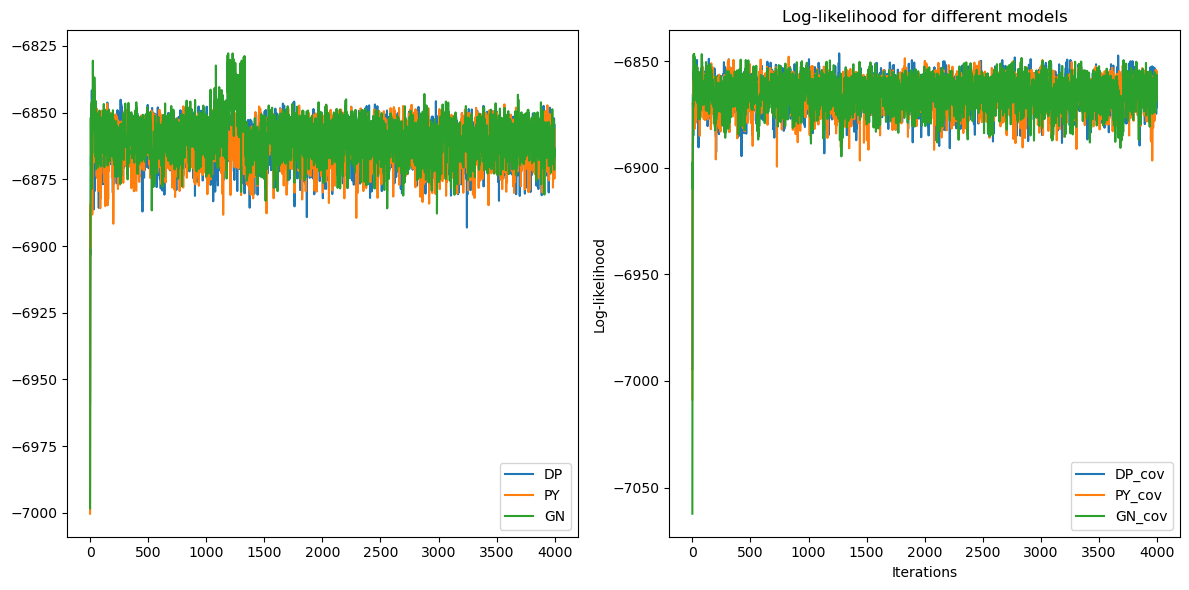

In [ ]:
llk_dp_esbm = model_dp_esbm.train_llk
llk_py_esbm = model_py_esbm.train_llk
llk_gn_esbm = model_gn_esbm.train_llk
llk_dp_cov_esbm = model_dp_cov_esbm.train_llk
llk_py_cov_esbm = model_py_cov_esbm.train_llk
llk_gn_cov_esbm = model_gn_cov_esbm.train_llk

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(llk_dp_esbm[2:], label='DP')
ax[0].plot(llk_py_esbm[2:], label='PY')
ax[0].plot(llk_gn_esbm[2:], label='GN')
ax[0].legend()

ax[1].plot(llk_dp_cov_esbm[2:], label='DP_cov')
ax[1].plot(llk_py_cov_esbm[2:], label='PY_cov')
ax[1].plot(llk_gn_cov_esbm[2:], label='GN_cov')
ax[1].legend()

plt.title('Log-likelihood for different models')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

plt.tight_layout()
plt.show()